Simulation Results Summary:
Total cost: $7790.73
Total emissions: 17400903.07 gCO2
Average solar panels used: 21.9
Average wind turbines used: 29.6
Average grid power: 342.7 kW
Average battery level: 188.0 kWh


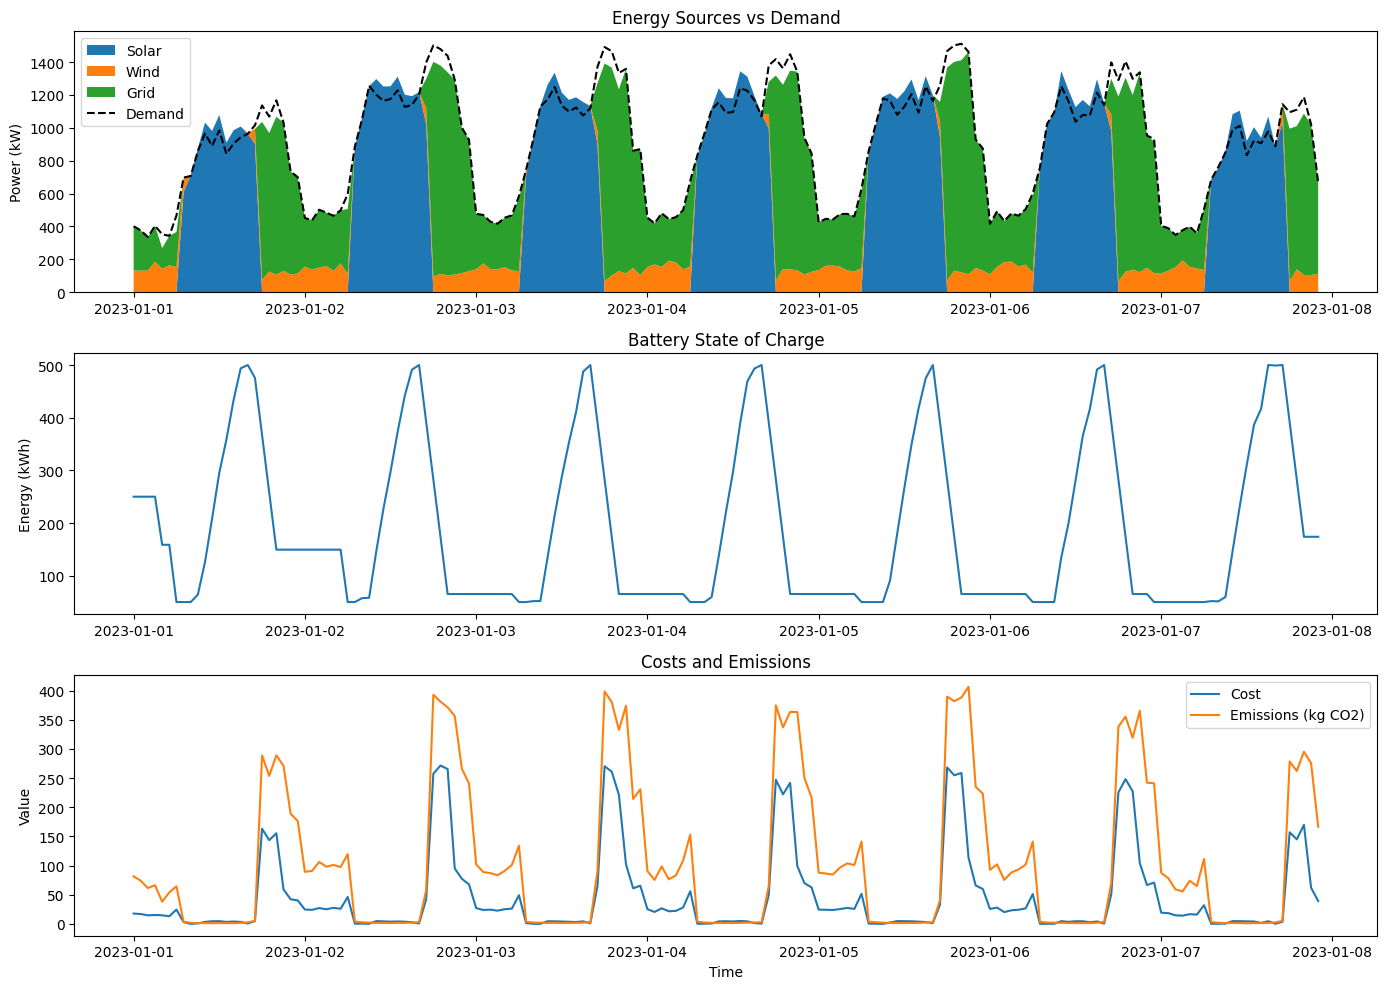

In [2]:
import numpy as np
import pandas as pd
import pulp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class HybridEnergyMPC:
    def __init__(self, prediction_horizon=24):
        """
        Initialize the Model Predictive Control system for hybrid energy management.
        
        Args:
            prediction_horizon (int): Number of time steps to look ahead for optimization
        """
        # System parameters
        self.max_solar_panels = 100
        self.max_wind_turbines = 50
        self.panel_capacity = 300  # Watts per panel
        self.turbine_capacity = 10  # kW per turbine
        self.solar_efficiency = 0.2
        self.wind_efficiency = 0.5
        
        # Energy storage parameters
        self.battery_capacity = 500  # kWh
        self.battery_efficiency = 0.92  # Round-trip efficiency
        self.max_charge_rate = 100  # kW
        self.max_discharge_rate = 100  # kW
        self.min_battery_level = 0.1  # Minimum 10% charge
        
        # Economic parameters
        self.panel_cost = 2.75  # $ per Watt installed
        self.panel_lifetime = 25  # years
        self.turbine_cost = 1500  # $ per kW installed
        self.turbine_lifetime = 25  # years
        self.battery_cost = 400  # $ per kWh
        self.battery_lifetime = 10  # years
        self.battery_cycle_cost = 0.05  # $ per kWh throughput
        
        # Emission factors (gCO2/kWh)
        self.EF_PV = 50  # per panel
        self.EF_WT = 10  # per turbine
        self.EF_grid = 300  # per kWh from grid
        self.EF_battery = 100  # per kWh throughput
        
        # MPC parameters
        self.prediction_horizon = prediction_horizon
        
        # Current system state
        self.current_battery_charge = 0.5  # Start at 50% charge
        
        # Weights for multi-objective optimization
        self.cost_weight = 0.5
        self.emission_weight = 0.5
    
    def forecast_error_model(self, forecast_horizon):
        """
        Model the increasing uncertainty in forecasts with longer horizons.
        
        Args:
            forecast_horizon (int): Hours ahead in the forecast
            
        Returns:
            float: Standard deviation of the forecast error
        """
        # Simple model where error grows with the square root of time
        base_error = 0.05  # 5% error in the immediate forecast
        return base_error * np.sqrt(forecast_horizon)
    
    def generate_weather_scenarios(self, base_forecasts, num_scenarios=5):
        """
        Generate multiple weather scenarios based on forecast uncertainty.
        
        Args:
            base_forecasts (dict): Dictionary containing base forecasts for solar and wind
            num_scenarios (int): Number of scenarios to generate
            
        Returns:
            list: List of scenario dictionaries
        """
        scenarios = []
        
        for s in range(num_scenarios):
            scenario = {'solar': [], 'wind': []}
            
            for t in range(self.prediction_horizon):
                # Increasing uncertainty with forecast horizon
                error_factor = self.forecast_error_model(t)
                
                # Generate perturbed forecast
                solar_error = np.random.normal(0, error_factor * base_forecasts['solar'][t])
                wind_error = np.random.normal(0, error_factor * base_forecasts['wind'][t])
                
                # Ensure non-negative values
                scenario['solar'].append(max(0, base_forecasts['solar'][t] + solar_error))
                scenario['wind'].append(max(0, base_forecasts['wind'][t] + wind_error))
            
            scenarios.append(scenario)
        
        return scenarios
    
    def create_optimization_model(self, current_state, scenario, grid_prices, energy_demand):
      """
      Create a MILP optimization model for a given scenario.
      
      Args:
          current_state (dict): Current system state including battery charge
          scenario (dict): Weather scenario with solar and wind forecasts
          grid_prices (list): Forecasted grid prices for the prediction horizon
          energy_demand (list): Forecasted energy demand for the prediction horizon
          
      Returns:
          tuple: (model, variables) - PuLP model and decision variables
      """
      model = pulp.LpProblem("Energy_Optimization", pulp.LpMinimize)
      
      # Decision variables for each time step in the horizon
      variables = {
          'n_pv': [],     # Number of solar panels to use
          'n_wt': [],     # Number of wind turbines to use
          'p_grid': [],   # Power from grid
          'p_batt_charge': [],    # Power to charge battery
          'p_batt_discharge': [], # Power from battery discharge
          'batt_level': []        # Battery charge level
      }
      
      # Initialize battery level
      battery_level = current_state['battery_charge'] * self.battery_capacity
      
      # Create variables for each time step
      for t in range(self.prediction_horizon):
          variables['n_pv'].append(
              pulp.LpVariable(f"n_pv_{t}", lowBound=0, upBound=self.max_solar_panels, cat='Integer')
          )
          variables['n_wt'].append(
              pulp.LpVariable(f"n_wt_{t}", lowBound=0, upBound=self.max_wind_turbines, cat='Integer')
          )
          variables['p_grid'].append(
              pulp.LpVariable(f"p_grid_{t}", lowBound=0, cat='Continuous')
          )
          variables['p_batt_charge'].append(
              pulp.LpVariable(f"p_batt_charge_{t}", lowBound=0, upBound=self.max_charge_rate, cat='Continuous')
          )
          variables['p_batt_discharge'].append(
              pulp.LpVariable(f"p_batt_discharge_{t}", lowBound=0, upBound=self.max_discharge_rate, cat='Continuous')
          )
          variables['batt_level'].append(
              pulp.LpVariable(f"batt_level_{t}", 
                            lowBound=self.min_battery_level * self.battery_capacity, 
                            upBound=self.battery_capacity, 
                            cat='Continuous')
          )
      
      # Objective function: minimize cost and emissions over the horizon
      objective = 0
      
      for t in range(self.prediction_horizon):
          # Economic costs
          solar_cost = self.panel_cost * self.panel_capacity * variables['n_pv'][t] / (self.panel_lifetime * 365 * 24)
          wind_cost = self.turbine_cost * self.turbine_capacity * variables['n_wt'][t] / (self.turbine_lifetime * 365 * 24)
          grid_cost = grid_prices[t] * variables['p_grid'][t]
          battery_cost = self.battery_cycle_cost * (variables['p_batt_charge'][t] + variables['p_batt_discharge'][t])
          
          # Emission costs
          solar_emissions = self.EF_PV * variables['n_pv'][t] 
          wind_emissions = self.EF_WT * variables['n_wt'][t]
          grid_emissions = self.EF_grid * variables['p_grid'][t]
          battery_emissions = self.EF_battery * (variables['p_batt_charge'][t] + variables['p_batt_discharge'][t]) / self.battery_capacity
          
          # Total objective for this time step
          time_step_objective = (
              self.cost_weight * (solar_cost + wind_cost + grid_cost + battery_cost) +
              self.emission_weight * (solar_emissions + wind_emissions + grid_emissions + battery_emissions)
          )
          
          objective += time_step_objective
      
      model += objective
      
      # Constraints
      for t in range(self.prediction_horizon):
          # Calculate renewable energy production
          solar_output = scenario['solar'][t] * self.panel_capacity * self.solar_efficiency * variables['n_pv'][t] / 1000  # Convert to kW
          wind_output = scenario['wind'][t] * self.turbine_capacity * self.wind_efficiency * variables['n_wt'][t] / 20  # Scaling factor for wind
          
          # Energy balance constraint: supply must meet demand
          model += (
              solar_output + 
              wind_output + 
              variables['p_grid'][t] + 
              variables['p_batt_discharge'][t] - 
              variables['p_batt_charge'][t] >= 
              energy_demand[t]
          )
          
          # Battery dynamics constraints
          if t == 0:
              # Initial battery level
              model += (
                  variables['batt_level'][t] * self.battery_efficiency == 
                  battery_level * self.battery_efficiency + 
                  variables['p_batt_charge'][t] * self.battery_efficiency**2 - 
                  variables['p_batt_discharge'][t]
              )
          else:
              # Battery level depends on previous state and charge/discharge
              model += (
                  variables['batt_level'][t] * self.battery_efficiency == 
                  variables['batt_level'][t-1] * self.battery_efficiency + 
                  variables['p_batt_charge'][t] * self.battery_efficiency**2 - 
                  variables['p_batt_discharge'][t]
              )
      
      return model, variables
    
    def evaluate_solution_robustness(self, solution, scenarios, grid_prices, energy_demand):
        """
        Evaluate a solution across multiple scenarios to assess robustness.
        
        Args:
            solution (dict): Optimized decision variables for the first solution
            scenarios (list): List of weather scenarios
            grid_prices (list): Forecasted grid prices
            energy_demand (list): Forecasted energy demand
            
        Returns:
            float: Expected cost across scenarios
        """
        total_expected_cost = 0
        
        # We only care about the first time step's decisions
        n_pv = solution['n_pv']
        n_wt = solution['n_wt']
        p_batt_charge = solution['p_batt_charge']
        p_batt_discharge = solution['p_batt_discharge']
        
        for scenario in scenarios:
            # Calculate renewable generation in this scenario
            solar_output = scenario['solar'][0] * self.panel_capacity * self.solar_efficiency * n_pv / 1000
            wind_output = scenario['wind'][0] * self.turbine_capacity * self.wind_efficiency * n_wt / 20
            
            # Calculate grid power needed
            p_grid = max(0, energy_demand[0] - solar_output - wind_output - p_batt_discharge + p_batt_charge)
            
            # Calculate costs for this scenario
            solar_cost = self.panel_cost * self.panel_capacity * n_pv / (self.panel_lifetime * 365 * 24)
            wind_cost = self.turbine_cost * self.turbine_capacity * n_wt / (self.turbine_lifetime * 365 * 24)
            grid_cost = grid_prices[0] * p_grid
            battery_cost = self.battery_cycle_cost * (p_batt_charge + p_batt_discharge)
            
            # Calculate emissions
            solar_emissions = self.EF_PV * n_pv 
            wind_emissions = self.EF_WT * n_wt
            grid_emissions = self.EF_grid * p_grid
            battery_emissions = self.EF_battery * (p_batt_charge + p_batt_discharge) / self.battery_capacity
            
            # Total scenario cost
            scenario_cost = (
                self.cost_weight * (solar_cost + wind_cost + grid_cost + battery_cost) +
                self.emission_weight * (solar_emissions + wind_emissions + grid_emissions + battery_emissions)
            )
            
            total_expected_cost += scenario_cost
        
        return total_expected_cost / len(scenarios)
    
    def mpc_step(self, current_time, weather_data, price_data, demand_data):
        """
        Execute one step of MPC optimization.
        
        Args:
            current_time (datetime): Current simulation time
            weather_data (DataFrame): Historical and forecast weather data
            price_data (DataFrame): Grid price data
            demand_data (DataFrame): Energy demand data
            
        Returns:
            dict: Optimal actions for the current time step
        """
        # Extract forecasts for the prediction horizon
        forecast_times = [current_time + timedelta(hours=i) for i in range(self.prediction_horizon)]
        
        # Get weather forecasts
        base_forecasts = {
            'solar': [weather_data.loc[t, 'solar_irradiance'] if t in weather_data.index else 0 for t in forecast_times],
            'wind': [weather_data.loc[t, 'wind_speed'] if t in weather_data.index else 0 for t in forecast_times]
        }
        
        # Get price and demand forecasts
        grid_prices = [price_data.loc[t, 'price'] if t in price_data.index else 0.1 for t in forecast_times]
        energy_demand = [demand_data.loc[t, 'demand'] if t in demand_data.index else 1000 for t in forecast_times]
        
        # Generate multiple weather scenarios
        scenarios = self.generate_weather_scenarios(base_forecasts)
        
        # Current state
        current_state = {
            'battery_charge': self.current_battery_charge,
            'time': current_time
        }
        
        best_solution = None
        best_objective = float('inf')
        
        # Solve for each scenario
        for scenario in scenarios:
            # Create and solve optimization model
            model, variables = self.create_optimization_model(
                current_state, scenario, grid_prices, energy_demand
            )
            
            # Solve the model
            model.solve(pulp.PULP_CBC_CMD(msg=False))
            
            # Check if solution was found
            if model.status == pulp.LpStatusOptimal:
                # Extract solution values
                solution = {
                    'n_pv': variables['n_pv'][0].value(),
                    'n_wt': variables['n_wt'][0].value(),
                    'p_grid': variables['p_grid'][0].value(),
                    'p_batt_charge': variables['p_batt_charge'][0].value(),
                    'p_batt_discharge': variables['p_batt_discharge'][0].value(),
                    'batt_level': variables['batt_level'][0].value()
                }
                
                # Evaluate solution robustness across all scenarios
                objective = self.evaluate_solution_robustness(solution, scenarios, grid_prices, energy_demand)
                
                if objective < best_objective:
                    best_objective = objective
                    best_solution = solution
        
        # If no solution was found, use a fallback strategy
        if best_solution is None:
            best_solution = {
                'n_pv': self.max_solar_panels,
                'n_wt': self.max_wind_turbines,
                'p_grid': energy_demand[0],
                'p_batt_charge': 0,
                'p_batt_discharge': 0,
                'batt_level': self.current_battery_charge * self.battery_capacity
            }
        
        # Update battery state based on the solution
        self.current_battery_charge = best_solution['batt_level'] / self.battery_capacity
        
        return best_solution
    
    def simulate_system(self, start_time, end_time, weather_data, price_data, demand_data, time_step_hours=1):
        """
        Simulate the system over a period using MPC.
        
        Args:
            start_time (datetime): Simulation start time
            end_time (datetime): Simulation end time
            weather_data (DataFrame): Weather data indexed by datetime
            price_data (DataFrame): Grid price data indexed by datetime
            demand_data (DataFrame): Energy demand data indexed by datetime
            time_step_hours (float): Hours between simulation steps
            
        Returns:
            DataFrame: Results of the simulation
        """
        # Initialize results storage
        results = []
        
        # Run simulation
        current_time = start_time
        while current_time < end_time:
            # Execute MPC step
            solution = self.mpc_step(current_time, weather_data, price_data, demand_data)
            
            # Get actual weather and demand data for this time
            if current_time in weather_data.index:
                actual_solar = weather_data.loc[current_time, 'solar_irradiance']
                actual_wind = weather_data.loc[current_time, 'wind_speed']
            else:
                # Fallback if exact time not in data
                actual_solar = 0
                actual_wind = 0
            
            if current_time in demand_data.index:
                actual_demand = demand_data.loc[current_time, 'demand']
            else:
                actual_demand = 1000  # Default value
            
            if current_time in price_data.index:
                actual_price = price_data.loc[current_time, 'price']
            else:
                actual_price = 0.1  # Default value
            
            # Calculate actual renewable generation
            n_pv = int(solution['n_pv'])
            n_wt = int(solution['n_wt'])
            solar_output = actual_solar * self.panel_capacity * self.solar_efficiency * n_pv / 1000
            wind_output = actual_wind * self.turbine_capacity * self.wind_efficiency * n_wt / 20
            
            # Battery actions
            p_batt_charge = solution['p_batt_charge']
            p_batt_discharge = solution['p_batt_discharge']
            
            # Calculate actual grid power needed based on real values
            renewable_output = solar_output + wind_output
            p_grid = max(0, actual_demand - renewable_output - p_batt_discharge + p_batt_charge)
            
            # Calculate costs
            solar_cost = self.panel_cost * self.panel_capacity * n_pv / (self.panel_lifetime * 365 * 24)
            wind_cost = self.turbine_cost * self.turbine_capacity * n_wt / (self.turbine_lifetime * 365 * 24)
            grid_cost = actual_price * p_grid
            battery_cost = self.battery_cycle_cost * (p_batt_charge + p_batt_discharge)
            total_cost = solar_cost + wind_cost + grid_cost + battery_cost
            
            # Calculate emissions
            solar_emissions = self.EF_PV * n_pv
            wind_emissions = self.EF_WT * n_wt
            grid_emissions = self.EF_grid * p_grid
            battery_emissions = self.EF_battery * (p_batt_charge + p_batt_discharge) / self.battery_capacity
            total_emissions = solar_emissions + wind_emissions + grid_emissions + battery_emissions
            
            # Record results
            results.append({
                'time': current_time,
                'n_pv': n_pv,
                'n_wt': n_wt,
                'solar_output': solar_output,
                'wind_output': wind_output,
                'p_grid': p_grid,
                'p_batt_charge': p_batt_charge,
                'p_batt_discharge': p_batt_discharge,
                'battery_level': self.current_battery_charge * self.battery_capacity,
                'demand': actual_demand,
                'grid_price': actual_price,
                'total_cost': total_cost,
                'total_emissions': total_emissions
            })
            
            # Move to next time step
            current_time += timedelta(hours=time_step_hours)
        
        return pd.DataFrame(results)


# Function to generate synthetic data for testing the MPC system
def generate_synthetic_data(start_time, end_time, time_step_hours=1):
    """
    Generate synthetic weather, price, and demand data for testing.
    
    Args:
        start_time (datetime): Start time
        end_time (datetime): End time
        time_step_hours (float): Hours between data points
        
    Returns:
        tuple: (weather_data, price_data, demand_data) - DataFrames with synthetic data
    """
    # Generate time index
    times = []
    current_time = start_time
    while current_time < end_time:
        times.append(current_time)
        current_time += timedelta(hours=time_step_hours)
    
    # Solar irradiance pattern (daily cycle with noise)
    solar_data = []
    for t in times:
        hour = t.hour
        # Solar pattern: 0 at night, peak at noon
        if 6 <= hour <= 18:
            base_solar = 800 * np.sin(np.pi * (hour - 6) / 12)
        else:
            base_solar = 0
        
        # Add seasonal adjustment
        month = t.month
        if 3 <= month <= 8:  # Spring/Summer
            seasonal_factor = 1.2
        else:  # Fall/Winter
            seasonal_factor = 0.8
        
        # Add random noise (±10%)
        noise = np.random.uniform(-0.1, 0.1)
        solar_data.append(max(0, base_solar * seasonal_factor * (1 + noise)))
    
    # Wind speed pattern (more complex pattern with daily and seasonal variations)
    wind_data = []
    for t in times:
        hour = t.hour
        month = t.month
        
        # Base wind pattern (higher at night)
        if 0 <= hour <= 6:
            base_wind = 8 + 2 * np.sin(np.pi * hour / 6)
        elif 6 < hour <= 18:
            base_wind = 5 + 3 * np.sin(np.pi * (hour - 6) / 12)
        else:
            base_wind = 7 + np.sin(np.pi * (hour - 18) / 6)
        
        # Seasonal adjustment
        if 11 <= month or month <= 2:  # Winter
            seasonal_factor = 1.3
        elif 3 <= month <= 5:  # Spring
            seasonal_factor = 1.1
        elif 6 <= month <= 8:  # Summer
            seasonal_factor = 0.8
        else:  # Fall
            seasonal_factor = 1.2
        
        # Add random noise (±20% since wind is more variable)
        noise = np.random.uniform(-0.2, 0.2)
        wind_data.append(max(0, base_wind * seasonal_factor * (1 + noise)))
    
    # Grid price pattern (time-of-use pricing with daily cycle)
    price_data = []
    for t in times:
        hour = t.hour
        
        # Time-of-use pricing
        if 0 <= hour < 6:  # Night (off-peak)
            base_price = 0.07
        elif 6 <= hour < 10:  # Morning (mid-peak)
            base_price = 0.10
        elif 10 <= hour < 17:  # Day (mid-peak)
            base_price = 0.12
        elif 17 <= hour < 21:  # Evening (peak)
            base_price = 0.20
        else:  # Night (off-peak)
            base_price = 0.08
        
        # Weekend discount
        if t.weekday() >= 5:  # Saturday or Sunday
            weekend_factor = 0.8
        else:
            weekend_factor = 1.0
        
        # Add slight random variation (±5%)
        noise = np.random.uniform(-0.05, 0.05)
        price_data.append(max(0.05, base_price * weekend_factor * (1 + noise)))
    
    # Energy demand pattern (daily cycle with weekday/weekend differences)
    demand_data = []
    for t in times:
        hour = t.hour
        
        # Daily pattern
        if 0 <= hour < 5:  # Late night
            base_demand = 400
        elif 5 <= hour < 9:  # Morning ramp-up
            base_demand = 400 + 600 * (hour - 5) / 4
        elif 9 <= hour < 17:  # Working hours
            base_demand = 1000
        elif 17 <= hour < 22:  # Evening peak
            base_demand = 1200
        else:  # Evening wind-down
            base_demand = 800
        
        # Weekday/weekend adjustment
        if t.weekday() >= 5:  # Weekend
            day_factor = 0.8
        else:  # Weekday
            day_factor = 1.0
        
        # Seasonal adjustment
        month = t.month
        if 6 <= month <= 8:  # Summer (higher demand for cooling)
            seasonal_factor = 1.2
        elif 12 <= month or month <= 2:  # Winter (higher demand for heating)
            seasonal_factor = 1.15
        else:  # Spring/Fall
            seasonal_factor = 0.9
        
        # Add random noise (±10%)
        noise = np.random.uniform(-0.1, 0.1)
        demand_data.append(max(200, base_demand * day_factor * seasonal_factor * (1 + noise)))
    
    # Create DataFrames
    weather_data = pd.DataFrame({
        'solar_irradiance': solar_data,
        'wind_speed': wind_data
    }, index=times)
    
    price_data = pd.DataFrame({
        'price': price_data
    }, index=times)
    
    demand_data = pd.DataFrame({
        'demand': demand_data
    }, index=times)
    
    return weather_data, price_data, demand_data


# Example usage
def run_mpc_simulation():
    """Run a simulation of the MPC system with synthetic data."""
    # Set up time range
    start_time = datetime(2023, 1, 1, 0, 0)
    end_time = datetime(2023, 1, 7, 23, 0)  # One week
    
    # Generate synthetic data
    weather_data, price_data, demand_data = generate_synthetic_data(start_time, end_time)
    
    # Create MPC controller
    mpc_controller = HybridEnergyMPC(prediction_horizon=24)
    
    # Run simulation
    results = mpc_controller.simulate_system(
        start_time, end_time, weather_data, price_data, demand_data
    )
    
    # Display results
    print("Simulation Results Summary:")
    print(f"Total cost: ${results['total_cost'].sum():.2f}")
    print(f"Total emissions: {results['total_emissions'].sum():.2f} gCO2")
    print(f"Average solar panels used: {results['n_pv'].mean():.1f}")
    print(f"Average wind turbines used: {results['n_wt'].mean():.1f}")
    print(f"Average grid power: {results['p_grid'].mean():.1f} kW")
    print(f"Average battery level: {results['battery_level'].mean():.1f} kWh")
    
    # Plot results
    plt.figure(figsize=(14, 10))
    
    # Plot energy sources
    plt.subplot(3, 1, 1)
    plt.stackplot(results['time'], 
                  results['solar_output'], 
                  results['wind_output'], 
                  results['p_grid'],
                  labels=['Solar', 'Wind', 'Grid'])
    plt.plot(results['time'], results['demand'], 'k--', label='Demand')
    plt.legend()
    plt.title('Energy Sources vs Demand')
    plt.ylabel('Power (kW)')
    
    # Plot battery level
    plt.subplot(3, 1, 2)
    plt.plot(results['time'], results['battery_level'])
    plt.title('Battery State of Charge')
    plt.ylabel('Energy (kWh)')
    
    # Plot costs
    plt.subplot(3, 1, 3)
    plt.plot(results['time'], results['total_cost'], label='Cost')
    plt.plot(results['time'], results['total_emissions'] / 1000, label='Emissions (kg CO2)')
    plt.legend()
    plt.title('Costs and Emissions')
    plt.ylabel('Value')
    plt.xlabel('Time')
    
    plt.tight_layout()
    plt.show()
    
    return results

if __name__ == "__main__":
    results = run_mpc_simulation()